In [1]:
#Import required packages and modules
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [310]:
#Load json file into dataframe: df
#print basic dataframe attributes
df = pd.read_json('logins.json')
df_shape = df.shape
print(f'The dataset contains {df_shape[0]} observations and {df_shape[1]} columns')

The dataset contains 93142 observations and 1 columns


### Part 1 ‑ Exploratory data analysis

In [311]:
df.columns

Index(['login_time'], dtype='object')

In [312]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [313]:
#Check to see where data ends
df.iloc[-1]

login_time   1970-04-13 18:54:23
Name: 93141, dtype: datetime64[ns]

The last entry in the data set shows a date of 4-13-1970, meaning we have incomplete data for the final month.  This will affect the plots because there is no data for the last two weeks of the sample.

In [10]:
df['count'] = 1

In [141]:
df_15 = df.groupby([pd.Grouper(key='login_time', freq='15min')])['count'].count().to_frame()
df_15.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [14]:
df.isnull().sum()

login_time    0
count         0
dtype: int64

In [ ]:
plt.style.use('ggplot')

Text(0, 0.5, 'login_count')

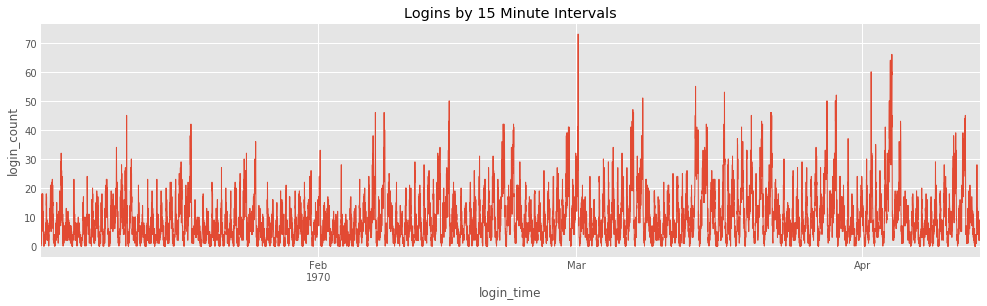

In [321]:
plt.figure(figsize=(15,4))
df_15['count'].plot(kind='line',linewidth=1)
plt.title('Logins by 15 Minute Intervals')
plt.ylabel('login_count')

Grouping the data in to 15 minute chunks reveals a repeating pattern in the data.  It looks as though there are 4 defined peaks occuring in each month so we can assume some type of weekly demand that rises and falls on a weekly basis over the course of a month.  Notice only two peaks in April, as we do not have data foe the last two weeks of that month.  In order to identify this, and any other underlying patters we sample the data at different time intervals for a closer look at the trends.

In [26]:
type(df_15.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [743]:
hour = df_15.resample('H').sum()
day = df_15.resample('D').sum()
week = df_15.resample('W').sum()
month = df_15.resample('M').sum()

In [744]:
plt.rcParams['figure.figsize'] = (10, 4)
def by_interval(df,title):
    plt.plot(df,linewidth=1)
    plt.title(title)
    plt.xticks(rotation = 45)
    plt.xlabel('Time')
    plt.ylabel('Count of Logins')

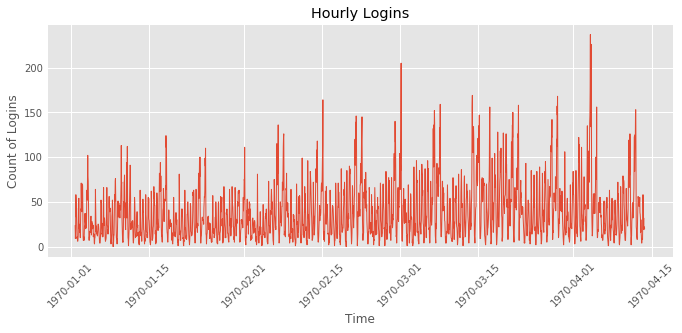

In [745]:
by_interval(hour,'Hourly Logins')

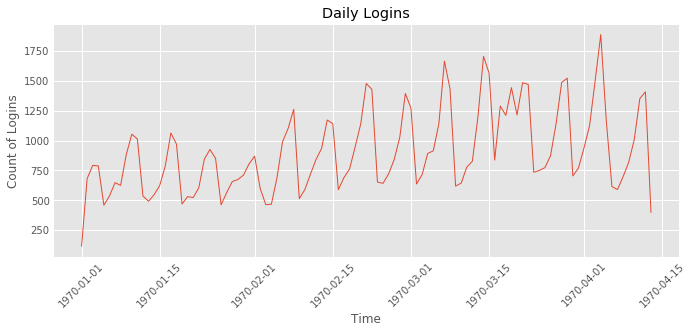

In [746]:
by_interval(day,'Daily Logins')

Resampling by day shows logins in weekly cycles.  Jan. 1 1970 was a Thursday, so it appears that logins increase sharply later in the week, and then drastically falls at the beginning of the week.  In addition to this weekly cycle, we also see a general trend of increased logins over the course of the period.  This general trend of increase is more visible in the following plots where the data was resampled by week and month.

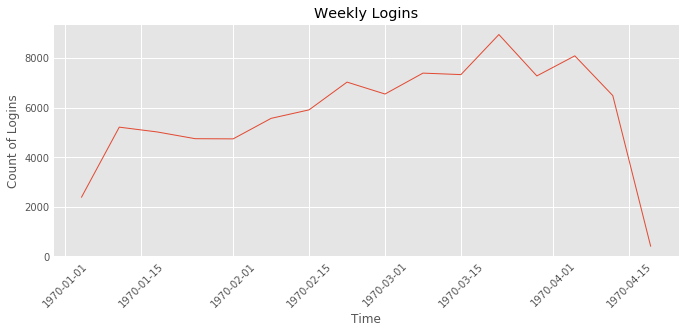

In [747]:
by_interval(week,'Weekly Logins')

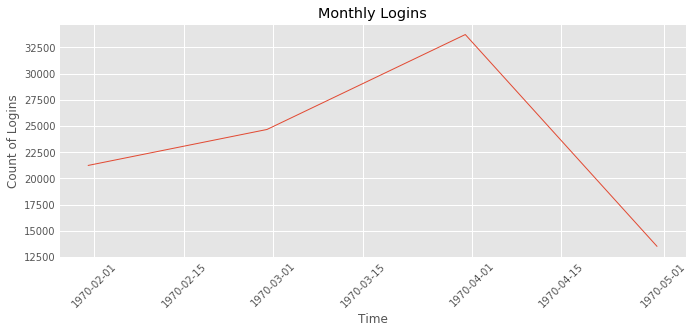

In [748]:
by_interval(month,'Monthly Logins')

Text(0.5, 1.0, 'Day of Week Average Logins')

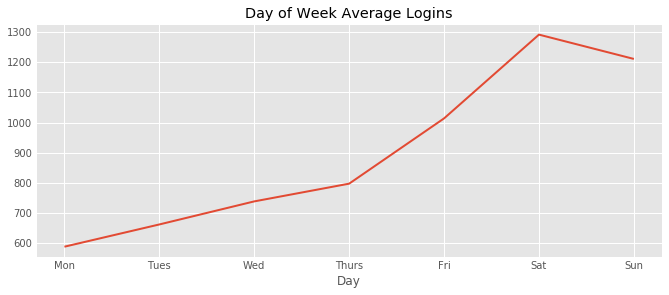

In [739]:
plt.rcParams['figure.figsize'] = (10, 4)
day = df_15.resample('D').sum()
day['weekday'] = day.index.weekday
by_weekday = day.groupby('weekday').mean()
day_list = ['Mon','Tues','Wed','Thurs','Fri','Sat','Sun']
by_weekday.reset_index(inplace=True)
by_weekday['Day'] = day_list
by_weekday.set_index('Day',inplace=True)
by_weekday['count'].plot(linewidth=2)
plt.title('Day of Week Average Logins')

Grouping the data by weekday confirm the general trend we say in the daily time seris plot.  Logins peak later in the week and then sharply decline around Sunday night.

Text(0.5, 1.0, 'Average Hourly Logins')

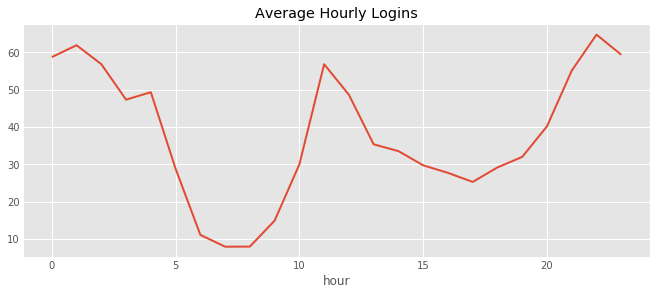

In [320]:
hour = df_15.resample('60min').sum()
hour['hour'] = hour.index.hour
by_hour = hour.groupby('hour').mean()
by_hour['count'].plot(linewidth=2)
plt.title('Average Hourly Logins')

Grouping the data by hour shows login rates over the course of the day.  It shows that users are loggin in during the morning, lunch time hours, and the evening.  This implies that the majority of the users are working during the day and logging into the app during lunch.  Whatever the app is, this user behavior is promising as it shows that people somewhat are dependent on the app.  What this chart shows is that users are loggin in the moment they have spare time.  This is further supported by the increase in logins over the weekend when people are not at work.

### Part 2 ‑ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.


1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?


### Key metric:

#### Count of times origin and destination city are not equal / all rides
Toll reimbursement could also be used as a metric.  However, since at the current time we are not offering reimbursements, choosing this as a metric would alter the way in which the experiment is conducted, and could introduce bias.  We would have to first implement the program in two stages.  Announce pilot program and collect data on toll reimbursements, then stop reimbursements, and collect data going further.  This may have the unintended negative consequence of upsetting driver partners.  If driver partners see their revenue increase due to the reimbursement, ending the program might upset drivers and cause them to be biased to their home city which would result in the opposite in what the company is trying to achieve.  
<br> By using Count of times origin and destination city are not equal as the key metric, we already have unbiased data as to how many times a driver partner crossed the toll.  This is historical data that we could pull to determine the rate in which driver partners went to the opposite city.  In this sense, the experiment can be conducted in one stage: Announce program and collect data.  This new data could then be compared to the historical data to see if there is any significant change.  


2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:

<br> a. how you will implement the experiment
<br> b. what statistical test(s) you will conduct to verify the significance of the
      observation
<br> c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.



### How to implement the experiment.
#### Determine the timeframe and duration in which to conduct the experiment.

<br>Being that the two cities are on opposite schedules during the weekday with approximately equal amounts of activity during the weekends, the experiment should be conducted on the weekend days.  This decision is supported by the fact that people would be more prone to travel to the opposite city on the weekends when activity levels are equal.  There might be events or attractions exclusive to one city, and people from the opposite city would most likely be traveling to them on the weekend days.  Furthermore, in addition to the toll reimbursement, drivers would be incentivized to travel to the opposite city being more confident they can get fares in both directions.  During the weekdays when activity levels are opposing, driver partners are less likely to gain a fare in both directions.  This could also impact the company financially as there is potential for two toll reimbursments when there was only one fare.

<br>Now that it has been determined that the experiment should be conducted on the weekends, a timeframe needs to be selected.  Since unbiased historical data for our metric has already been collected, we need to find a good time and duration to conduct the experiment.  We want to choose a time where ridership is historically high.  This is usually in the summer months.  Since we want to collect a good amount of information, we conduct the experiment on the weekends of months June, July, August.

<br>In order to implement the experiment, we first need to send a notification all the users and driver partners announcing the beginning of the program.  This is done to raise awareness and promote the new program.  Once this is done, we only need to wait for the data to arrive.

<br>Over the course of the experiment, we can begin to collect that data from the same months from the previous year.  We use this data for comparison to the data collected from the experiment.  An important caveat would be to normalize for the number of driver partners.  If driver partners increased/decreased significantly over the year, it would affect the results of our experiment.  Once the experiment is complete, we collect the new data and calculate the relevant metrics.



To determine the results of the experiment, we perform a paired, two-way t-test to either accept or reject the null hypothesis that there is no significant difference in the two groups key metric. 

#### what statistical test(s) you will conduct to verify the significance of the observation

To determine the results of the experiment, we perform a paired two-way t- test to either accept or reject the null hypothesis that there is no significant difference in the two groups key metric.  

#### Interpreting results and providing recommendations

The experiment conducted results in a binary outcome: key metric is the same, or key metric is different to a significant degree.  A two way t-test is used to determine whether the results are significantly different.  We either accept the null hypothesis that they are the same, or reject the null hypothesis and come to the conclusion that the results of the program are significantly different than the results from the historical data.

<br> In the event that the null hypothesis is accepted, we conclude that a statistically significant difference is not found.  In the business context, this would result in a loss of revenue as the company did not generate additional revenue from cross town rides to justify the toll reimburesment.  In this case the recommendation would be to stop the program until a new strategy is found that is proven to increase cross town ridership.  

<br> If the null hypothesis is rejected, then we can conclude that a significant difference exists between the two groups.  The next step would be to determine if the program generated more or less revenue for the company.  Since the company is offering toll reimbursements, there may exist a point where the total dollar amount exceeds the increase in revenue generated from the additional cross town rides.  If enough driver partners adopt the program it may not be financially viable to continue if the company is paying out more in reimburesments than it is taking in with increased revenue from cross town rides.  This scenario would be largely dependant on the cost of the toll.  The higher the toll, the more unlikely it may be to recover the costs of the program.  In this situation, it would be possible to adapt the reimbursement structure so that only a percentage of the toll is reimbursed.  This new percentage would have to be balanced to increase company revenue, while also satisfying the request that more driver partners are available in both cities. A new experiment would also need to be conducted to verify the results.

<br>The ideal scenario would be that the results of the experiment show an increase company revenue,  an increase the number of cross town rides, and an increase profit for the driver partners.  This result would have benefits for all parties involved.  The consumer would have more availability for cross town rides on the weekends, the driver partners would see an increase in take home pay, and the company would see an increase in revenue.  In this case, the recommendation would be to continue with the program, but monitor the results to ensure the program remain economically viable. 

### Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long­term rider retention (again, a few sentences will suffice).


In [754]:
#Load json file into dataframe: ult
#print basic dataframe attributes
ult = pd.read_json('ultimate_data_challenge.json')
ult_shape = ult.shape
print(f'The dataset contains {ult_shape[0]} observations and {ult_shape[1]} columns')

The dataset contains 50000 observations and 12 columns


In [755]:
ult.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [756]:
#check for null values
ult.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [757]:
#look at data types
ult.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [758]:
#check object type in date column
print(type(ult['signup_date'][0]))
print(type(ult['last_trip_date'][0]))

<class 'str'>
<class 'str'>


In [761]:
#convert strings to datetime objects
ult['signup_date'] = pd.to_datetime(ult['signup_date'])
ult['last_trip_date'] = pd.to_datetime(ult['last_trip_date'])

In [762]:
ult.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [694]:
#find date range of the data
print(ult['signup_date'].min())
print(ult['last_trip_date'].max())

2014-01-01 00:00:00
2014-07-01 00:00:00


In [783]:
#create column last_day and convert to dateteime
ult['last_day'] = '2014-07-01'
ult['last_day'] = pd.to_datetime(ult['last_day'])

#calculate the time between last day and last trip date
ult['time_delta'] = ult['last_day'] - ult['last_trip_date']

#create binary response variable for the target class (retained if ride in preceeding 30 days)
ult['retained'] = ult['time_delta'].apply(lambda x: True if x.days <= 30 else False)
ult.drop(['last_day','time_delta'],axis=1,inplace=True)

#convert to integer
ult['retained'] = ult['retained'] * 1

f"The percentage of retained users is {round(ult['retained'].value_counts(normalize=True)[1],3)*100}%"

'The percentage of retained users is 37.6%'

The main cleaning steps were to convert the date columns to datetime objects, and create a binary response variable for the target class.  We note that 3 columns had null values, and 3 columns that need to be encoded.  

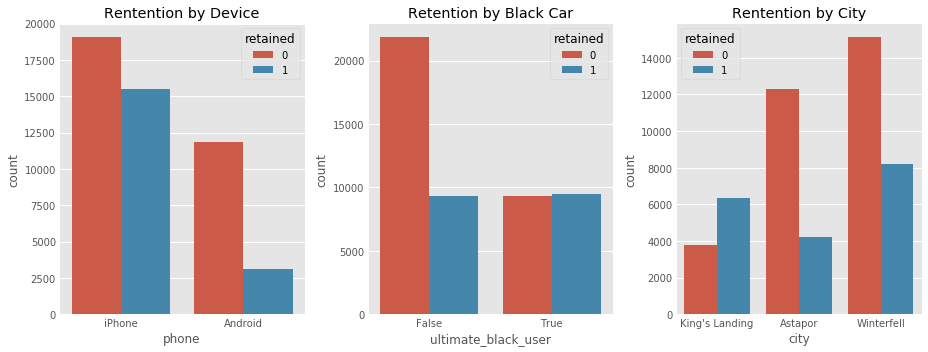

In [821]:
#plot categorical features by target class
plt.rcParams['figure.figsize'] = (13,5)
fig , ax = plt.subplots(1,3)
ax1 = sns.countplot(x='phone',hue='retained',data=ult,ax=ax[0])
ax1.set_title('Rentention by Device')
ax2 = sns.countplot(x='ultimate_black_user',hue='retained',data=ult,ax=ax[1])
ax2.set_title('Retention by Black Car')
ax3 = sns.countplot(x='city',hue='retained',data=ult,ax=ax[2])
ax3.set_title('Rentention by City')

fig.tight_layout()

Looking at count plots for the categorcal features show some interesting patterns.  Retention by black car, and retention by city both show instances where retention is greater than churn.  King's Landing shows more people retaining than leaving the app, which is the same case for users that took a black car ride in the first days, but only slightly.  These two categorical features could show strong predictive power to the postive class as this behavior differs from the rest.

In [702]:
ult['ultimate_black_user'] = ult['ultimate_black_user'] * 1

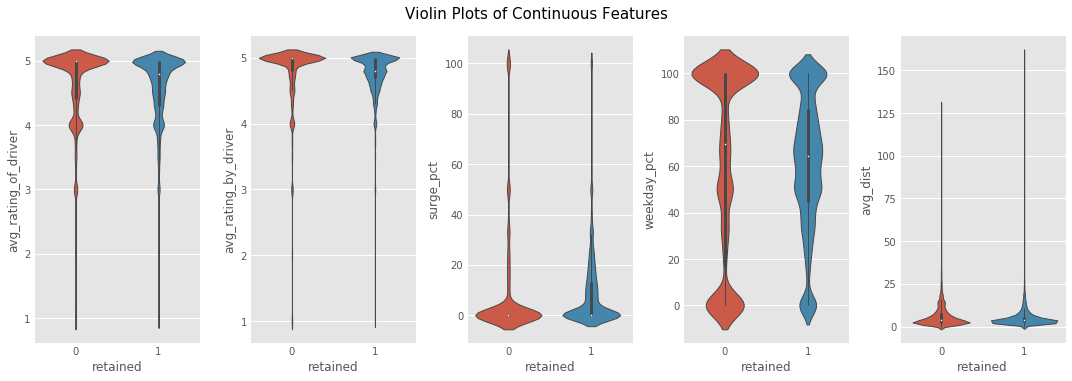

In [785]:
#plot continuous features differentiated by target class
fig , ax = plt.subplots(1,5,figsize=(15,5))
fig.suptitle('Violin Plots of Continuous Features',fontsize=15,y=1.05)
ax1 = sns.violinplot(x='retained',y='avg_rating_of_driver',data=ult,ax=ax[0],linewidth=1)
ax2 = sns.violinplot(x='retained',y='avg_rating_by_driver',data=ult,ax=ax[1],linewidth=1)
ax3 = sns.violinplot(x='retained',y='surge_pct',data=ult,ax=ax[2],linewidth=1)
ax4 = sns.violinplot(x='retained',y='weekday_pct',data=ult,ax=ax[3],linewidth=1)
ax5 = sns.violinplot(x='retained',y='avg_dist',data=ult,ax=ax[4],linewidth=1)
fig.tight_layout()

In [837]:
left = ult[ult['retained'] == 0]['trips_in_first_30_days']
stayed = ult[ult['retained'] == 1]['trips_in_first_30_days']

Text(0.5, 1.0, 'Trips in First 30 Days (by class)')

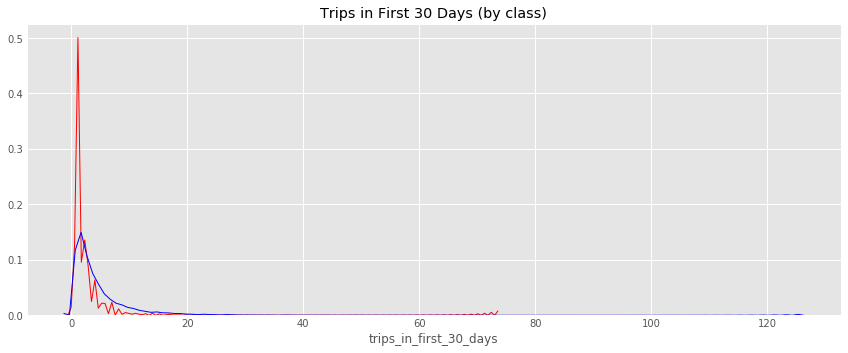

In [846]:
sns.distplot(left,color='red',kde_kws=dict(linewidth=1),hist=False)
sns.distplot(stayed,color='blue',kde_kws=dict(linewidth=1),hist=False)
plt.title("Trips in First 30 Days (by class)")


The most interesting violin plot is the weekday_pct, as it shows the most variation of the continuous features.  The distribution of users who retained show less variance in the percentage of trips that took place on a weekday than unretained users. The unretained users show more of a tendency to only use the service for weekday/weekend only rides.  Looking at the avg_rating_of_driver shows that users who retained show more variance in their ratings than users who left.  So while users that left service gave more 5 star ratings, users who retained we more likely to put more thought into their rating.  This variance in rating signals that users who plan to stay take more care when giving a rating.

Text(0.5, 1.0, 'Target Class Distribution')

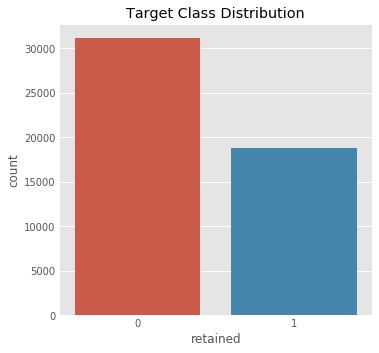

In [786]:
#plot distribution of target class
plt.rcParams['figure.figsize'] = (5,5)
sns.countplot(ult['retained'])
plt.title('Target Class Distribution')

Text(0.5, 1, 'Correlation Plot')

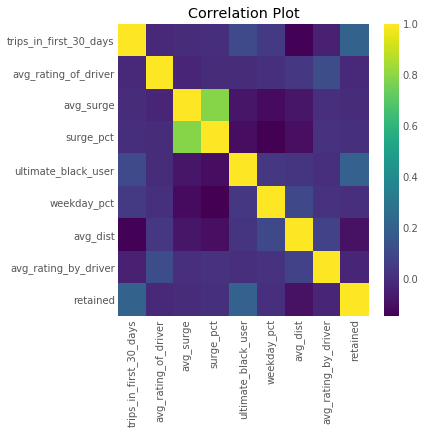

In [787]:
sns.heatmap(ult.corr(),cmap='viridis')
plt.title('Correlation Plot')

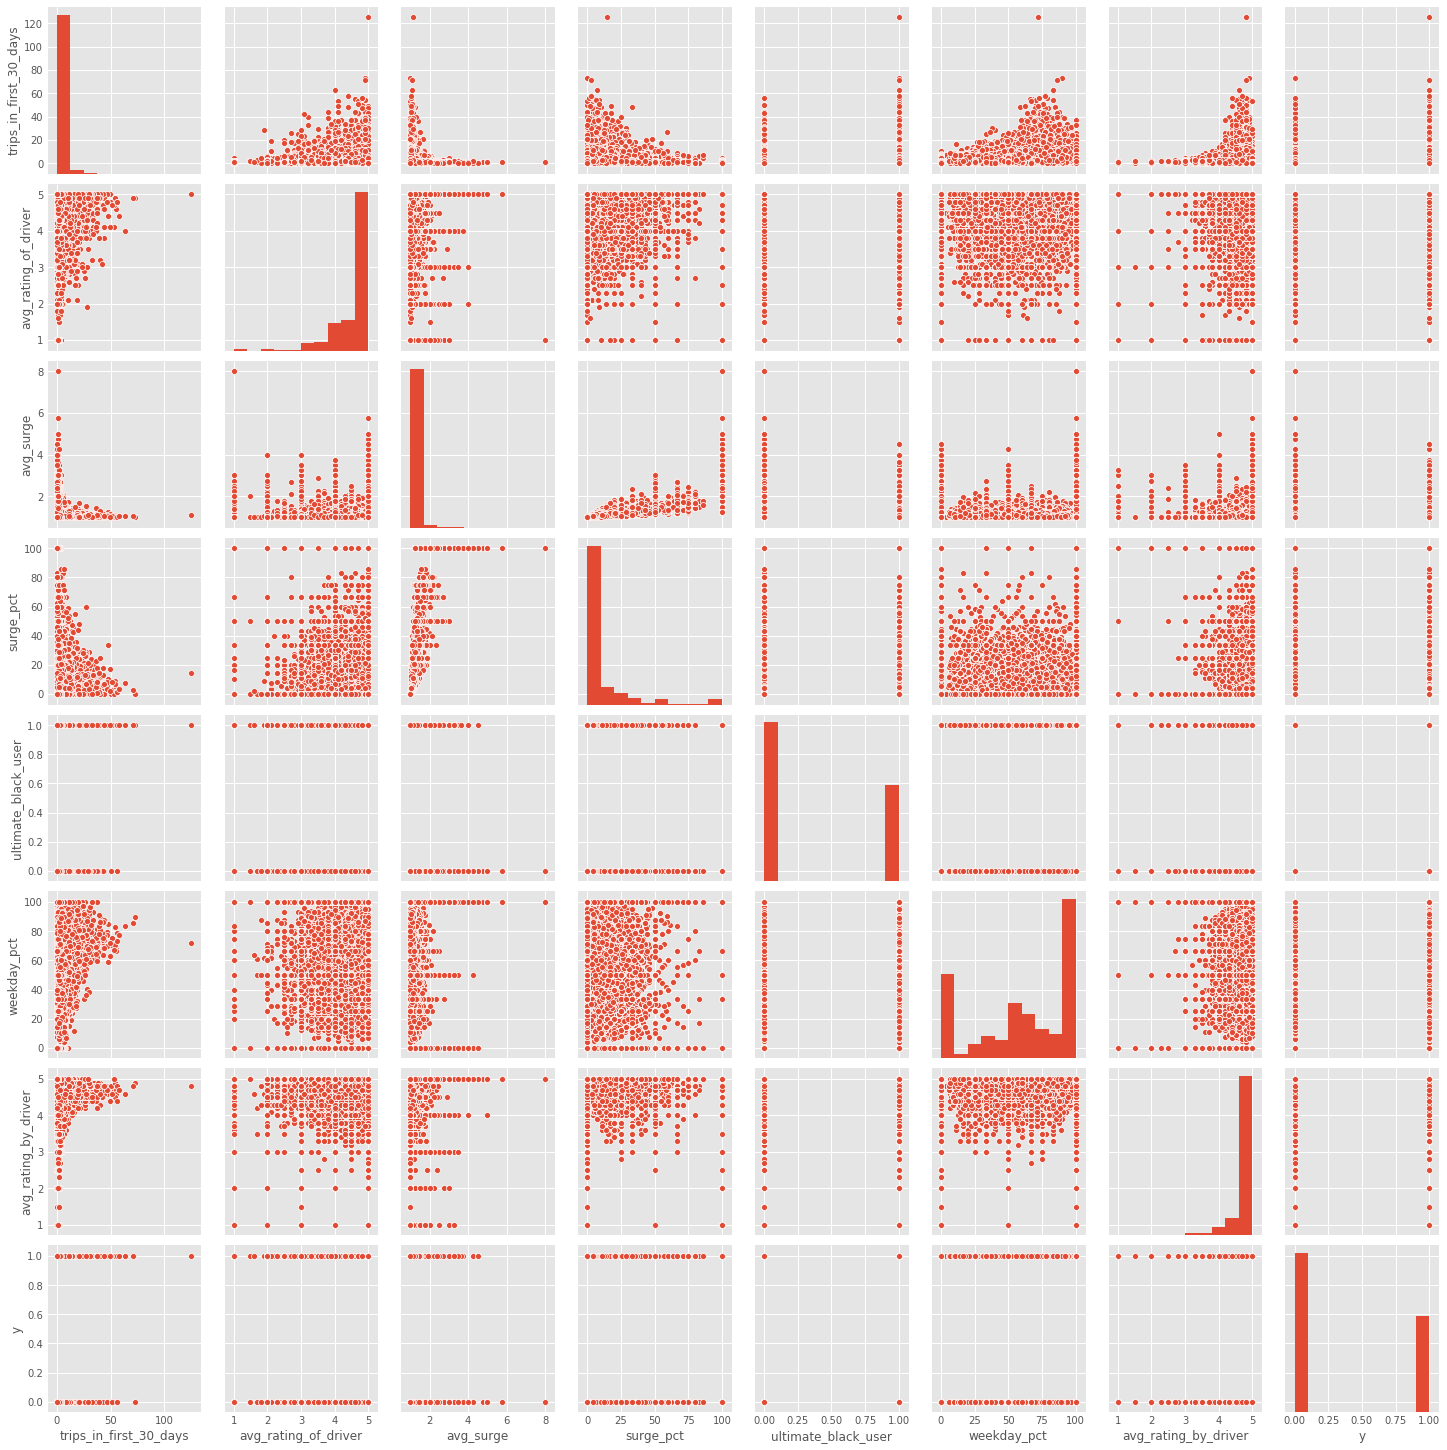

In [798]:
sns.pairplot(pair)

In [800]:
ult.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'retained'],
      dtype='object')

In [801]:
ults = ult.drop(['signup_date','last_trip_date'],axis=1)

In [802]:
ults.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,0


In [803]:
#create X and y variables
y = ults['retained']
X = ults.iloc[:,0:-1]

In [713]:
ult.corr()['retained']

trips_in_first_30_days    0.210463
avg_rating_of_driver     -0.011653
avg_surge                -0.003333
surge_pct                 0.011797
ultimate_black_user       0.205002
weekday_pct               0.009693
avg_dist                 -0.092780
avg_rating_by_driver     -0.026791
retained                  1.000000
Name: retained, dtype: float64

 ### Predictive model
 
 There are a few characteristics of the data that guide in selecting an algorithm for modeling.  Looking at the pairplot, we do not not see any linear relationships between the variables.  Likewise, none the the features themselves are normally distributed, or look like they could become that way with a transformation.  For these reasons we opt not to use a linear model, and instead use a tree based or ensemble model.  We also know that null values exist and the target class is imbalanced.  Xgboost will serve well here because it can handle both of these situations without further direct processing.  Xgboost, unlike other algorithms can accept null values, and has the hyper-parameter 'scale_pos_weight' that can affectively weight the target class.  This eliminates the need for over/undersampling of the data to balance the class.  In addition, feature importances can also be calculated to examine which variables play the strongest role in predicting the outcome.  Lastly, the model is fast, scales well, and is known to be the benchmark algorithm for tabular data. 

In [804]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, roc_curve, auc

In [805]:
X = pd.get_dummies(X, columns=["city","phone"])

In [806]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2)

In [807]:
from xgboost import XGBClassifier

In [808]:
clf = XGBClassifier(objective='binary:logistic')
# Set up parameter grid
param_grid_xgb = [
    { 'n_estimators': [50,100,150,200],
     'learning_rate': [0.01,0.1,0.2,0.3],
     'max_depth': range(3,10),
     'colsample_bytree': [i/10 for i in range(1,3)],
     'gamma': [i/10 for i in range(3)],
     'scale_pos_weight': [2,3],
     'reg_lambda': [1,5,10],
     'reg_alpha': [1,5,10]
    }]

In [809]:
# Instantiate random search with xgb_pipe pipeline
random_search_xgb = RandomizedSearchCV(clf, 
                                   param_distributions = param_grid_xgb, 
                                   cv=5, 
                                   verbose=0,
                                   n_jobs=-1,
                                   n_iter=25,
                                   scoring='roc_auc',
                                   random_state=1618)

In [810]:
%%time
# Fit filterd features pipeline to random search object
best_model_xgb = random_search_xgb.fit(X_train,y_train)

print(best_model_xgb.best_estimator_)
print("The AUC score of the model is:",best_model_xgb.score(X_test,y_test))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=5, reg_lambda=5, scale_pos_weight=2, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
The AUC score of the model is: 0.8563485501891932
Wall time: 35.2 s


In [811]:
# store predictions
y_pred_xgb = best_model_xgb.best_estimator_.predict(X_test)

#get classification report, convert to dataframe
xgb_report = classification_report(y_test,y_pred_xgb,output_dict=True)
report_xgb = pd.DataFrame(xgb_report).transpose()

In [812]:
report_xgb

,precision,recall,f1-score,support
0,0.862266,0.751924,0.803324,6236.0000
1,0.660894,0.801010,0.724237,3764.0000
accuracy,0.770400,0.770400,0.770400,0.7704
macro avg,0.761580,0.776467,0.763780,10000.0000
weighted avg,0.786469,0.770400,0.773556,10000.0000


In [813]:
confusion_matrix(y_test,y_preds)

array([[4779, 1457],
       [2920,  844]], dtype=int64)

In [814]:
print("The AUC score of the training data is:",best_model_xgb.score(X_train,y_train))
print("The AUC score of the tesing data is:",best_model_xgb.score(X_test,y_test))

The AUC score of the training data is: 0.8695712315236293
The AUC score of the tesing data is: 0.8563485501891932


In [815]:
# obtain positive class probabilities on X_filt_test
y_pred_xgb_probs = best_model_xgb.best_estimator_.predict_proba(X_test)
xgb_preds = y_pred_xgb_probs[:,1]

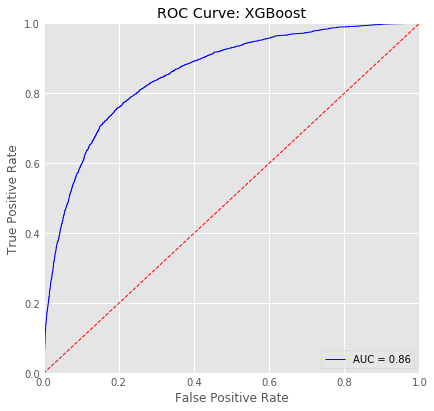

In [816]:
#plot roc curve
plt.rcParams['figure.figsize'] = (6,6)
fpr, tpr, threshold = roc_curve(y_test, xgb_preds)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve: XGBoost')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc,linewidth=1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--',linewidth=1)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0.5, 1.0, 'Feature Importances')

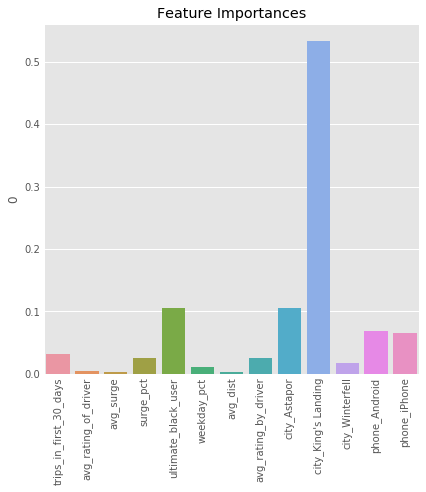

In [817]:
importance = best_model_xgb.best_estimator_.feature_importances_
features = X.columns
feats = dict(zip(features,importance))
feats = pd.DataFrame(index=feats.keys(),data=feats.values())
feature_importance = sns.barplot(x=feats.index,y=feats[0],data=feats)
feature_importance.set_xticklabels(feature_importance.get_xticklabels(), rotation=90)
plt.title("Feature Importances")

### Results

Using Xgboost, we obtain a predictive model with train/test AUC scores of 0.869 and 0.856, respectively.  This is an indication that the model will generalize well to new data as the model only seems to slightly overfit, making it a reliable model.  Due to the imbalance of the target class, auc is chosen as the evaluation metric instead of accuracy. While a test auc of 86.5% is a decent metric, we want to minimize the classification of false positives.  Examining the confusion matrix shows about twice as many false negatives that false positives.  This behavior is ideal as false positives label a user as 'retained' when in actuality they did not.  Identifying these users is crucial in increasing the rentention rate.  False negatives do not hurt the business is a direct sense, as the model predicted these users as unretained when the user actually stayed.  These misclassifications could only affect the business if a marketing strategy is implemented that offers reduced rates or other incentives that encourage these users to continue with the service.  

To interpret the model we plot the feature importance of the independent features.  By far, residing in the city of King's Landing is the best predictor of retention.  This was noted during the EDA process where the countplot showed this city was the only one where more users retained, than left.  The next variable that has a string influence on the model is 'ultimate_black_user,' where it was found that users not taking  a black car ride in the first 30 days are more than twice as likely to leave the service.  The next best indicator of retention according to the feature importance plot is the trips is first 30 days variable.  The distribution plot of the variable by class shows that users who took more than 2 rides in the first 30 days were more likely to retain.


### Recommendations

The focus for recommendations lie in the features that can be influenced.  Overall, riders who used the service more are mor likely to retain.

- **City:** We know that the city of King's Landing is the only location where more users are retaining than not.  It is important to understand why this is the case.  Is Ultimate's service the only available in King's Landing?  Not having other options for ride service could influence users to stay with the service.  Does the geographical space differ in King's Landing than the other two cities?  What about lack of public transportation?  These are uncontrollable factors that be pumping up the retention rate in King's Landing.  It would also be wise to take city population into account.  After drilling down on these questions, Ultimate could devise a marketing strategy that addresses these issues.  After answering these questions, the marketing department should focus on the other two cities to improve their retention rates. <br>


- **ultimate_black_user:** Exploratory data analysis shows that riders that do not use the black car service in the first 30 months are more than twice as likeley to leave.  To increase retention, the marketing department should devise a scheme that incentivizes user to take a black car ride in the first 30 days. <br>


- **trips_in_first_30_days:** Riders who took more than 2 trips in the first 30 days were more likely to retain.  To increase retention, some type of promotion should be offered to new users to encourage them to take more trips. I woud suggest something along the lines of 'take 4 rides, get 1 free (limited by distance).'  It's human nature to want 'free' stuff, so offering a free ride after 4 rides would encourage people to take those first 4 rides.  This would increase an individuals ride frequency, which we know is a key indicator of retention.  In order to keep people engaged with the service, this offer should be on a monthly basis.  